In [ ]:
!pip install plotly_express

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
df = pd.read_excel('rbidata.xlsx')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
data = df['Value']
data.index = pd.to_datetime(data.index)
data = data.asfreq('D')
data.head()

,Value
Date,
2020-06-01,4764.812000
2020-06-02,4781.974663
2020-06-03,4426.915552
2020-06-04,4424.531824
2020-06-05,4321.009311


In [ ]:
!pip install pymannkendall

In [ ]:
data.tail()

,Value
Date,
2025-02-21,3628.43
2025-02-22,3728.16
2025-02-23,3081.81
2025-02-24,3670.35
2025-02-25,3886.43


In [ ]:
print(df.isnull().sum())

Volume    0
Value     0
dtype: int64


In [ ]:
print(df.describe())

            Volume        Value
count  1731.000000  1731.000000
mean    105.097326  4402.472869
std      12.990471   754.007030
min      53.780000   296.828265
25%      97.065000  3869.955000
50%     104.770000  4346.730000
75%     113.880000  4963.775000
max     168.780000  7953.900000


In [ ]:
fig = px.line(data, height=400, title='Original Data Plot')
fig.show()

- This plot reveals a clear seasonal pattern, with recurring peaks and troughs suggesting periodic trends in transaction values. - The frequent spikes indicate high activity periods, possibly influenced by external factors such as paydays, financial cycles, or festive seasons.

#Decomposition

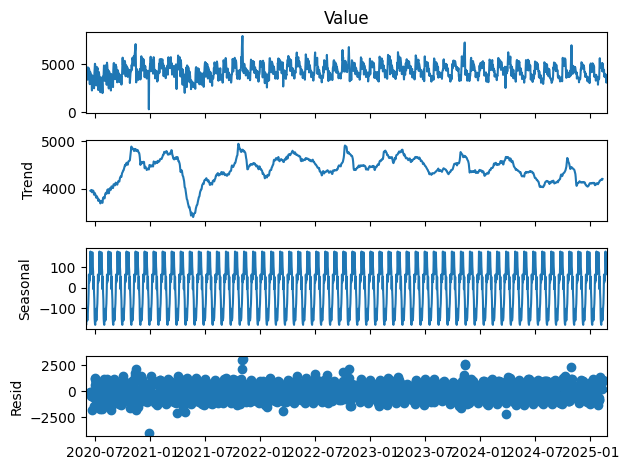

In [ ]:
additive_monthly=seasonal_decompose(data, model='additive',period=30)
additive_monthly.plot()
plt.show()

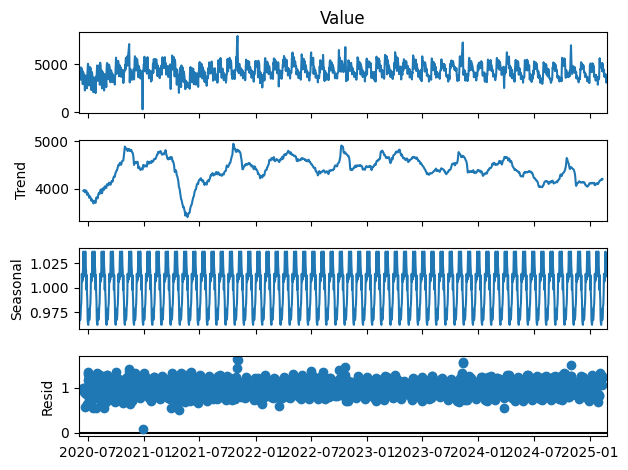

In [ ]:
multiplicative_monthly=seasonal_decompose(data, model='multiplicative',period=30)
multiplicative_monthly.plot()
plt.show()

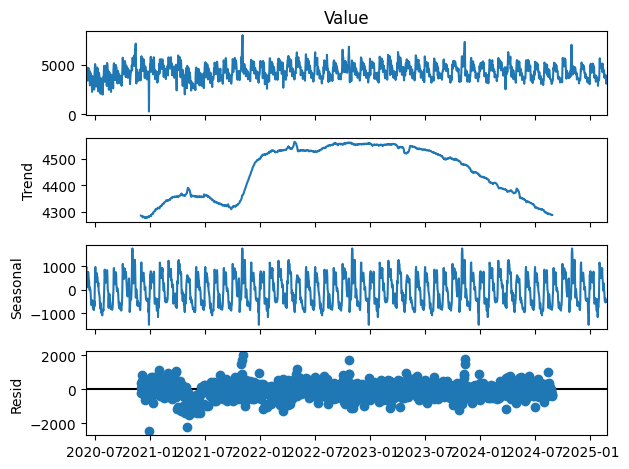

In [ ]:
additive_yearly=seasonal_decompose(data, model='additive',period=365)
additive_yearly.plot()
plt.show()

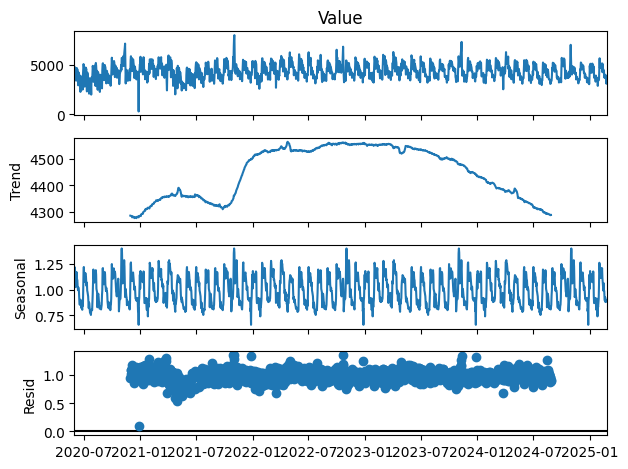

In [ ]:
multiplicative_yearly=seasonal_decompose(data, model='multiplicative',period=365)
multiplicative_yearly.plot()
plt.show()

#Stationarity

Checking Stationarity

Augmented Dickey-Fuller (ADF) test states:

- H₀: The time series has a unit root (i.e., it is non-stationary). This means the series has trend or seasonality.
- H₁: The time series is stationary.This means the series does not have a unit root.

- p-value < 0.05 → Reject H₀ → The series is stationary (No differencing needed).
- p-value ≥ 0.05 → Fail to reject H₀ → The series is non-stationary (Differencing required).

KPSS test states:

- H₀: The Series is trend stationarity(stable around a trend).
- H₁: The Series is not trend stationary.

- p-value < 0.05 → Reject H₀ → The Series is not trend stationarity (No differencing needed).
- p-value ≥ 0.05 → Fail to reject H₀ → The Series is trend stationarity(Differencing required).

In [ ]:
adf=adfuller(data)
print('The p-value of ADF test is',adf[1])
if adf[1]<0.05:
    print("Stationary")
else:
    print("Non-Stationary")
kp=kpss(data)
print('The p-value of KPSS test is',kp[1])
if kp[1]>0.05:
    print("Trend Stationary")
else:
    print("Non-Stationary")

The p-value of ADF test is 5.874992051262382e-06
Stationary
The p-value of KPSS test is 0.09510620390581694
Trend Stationary


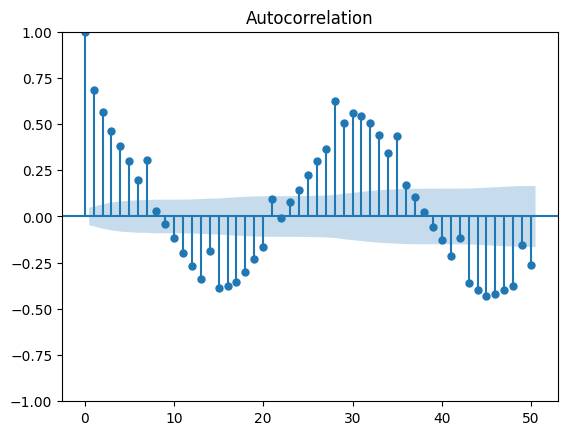

In [ ]:
acf=plot_acf(data,lags=50)
plt.show()

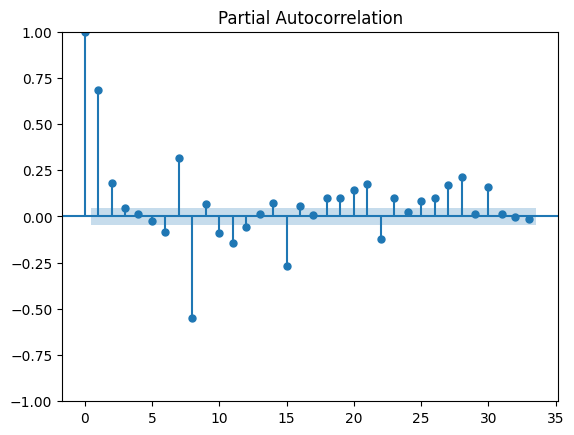

In [ ]:
pacf=plot_pacf(data)
plt.show()

#Differencing

To remove a deterministic trend from a time series, we can use detrending methods such as:
Differencing (for linear trends)
First-order differencing removes a linear trend:

In [ ]:
diff1 = data.diff().dropna() #initial de-trending

In [ ]:
fig = px.line(diff1, height=400, title='Lag1 Data Plot of train (de-trended)')
fig.show()

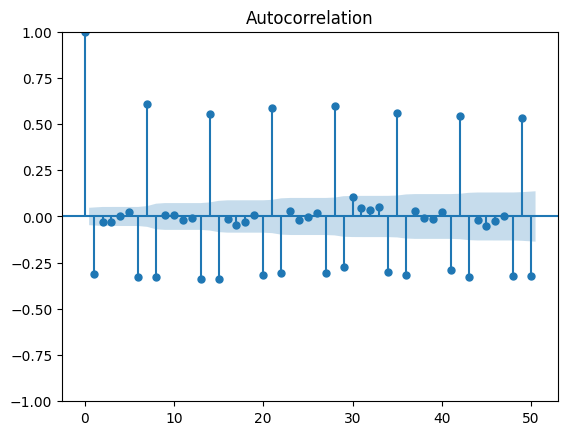

In [ ]:
plot_acf(diff1,lags=50)
plt.show()

- There is a weekly periodicity as expected
- Now we will remove seasonlity by taking a lag 7 to get other patterns

In [ ]:
diff_s = diff1.diff(7).dropna() #de-seasoning

In [ ]:
fig = px.line(diff_s, height=400)
fig.show()

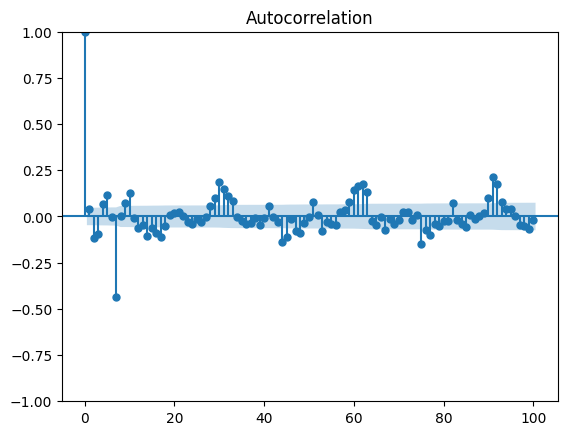

In [ ]:
plot_acf(diff_s,lags=100)
plt.show()

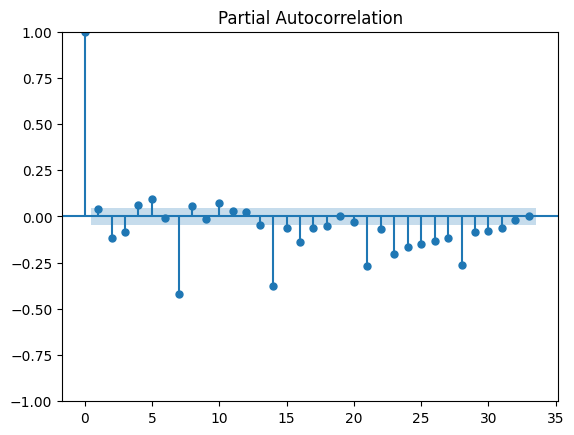

In [ ]:
plot_pacf(diff_s)
plt.show()

#Exponential Smoothing- trend=not present, seasonality-additive

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


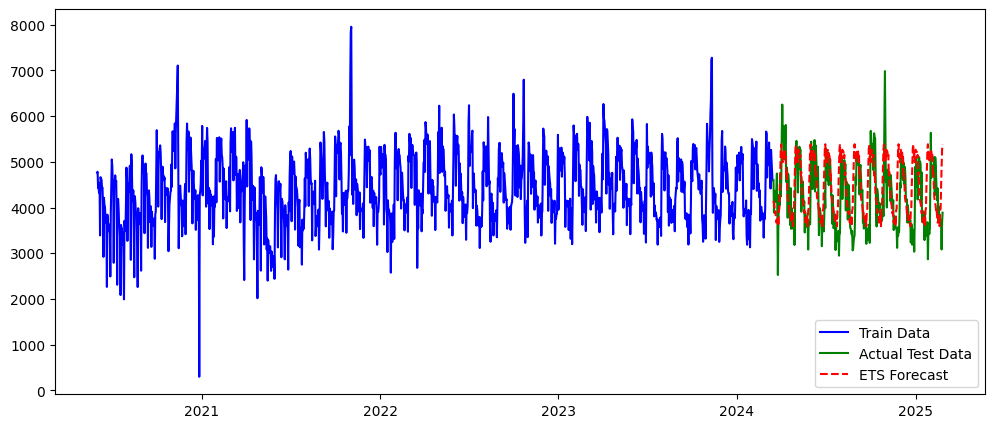

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd

train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

# Fit the ETS model on the training set
ets_model = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=30)
ets_fit = ets_model.fit()

test_data_with_forecast['ETS_Forecast'] = ets_fit.forecast(len(test_data)) #add forecast as column

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(train_data.index, train_data.values, label='Train Data', color='blue') # Access values directly
plt.plot(test_data.index, test_data.values, label='Actual Test Data', color='green') # Access values directly
plt.plot(test_data.index, test_data_with_forecast['ETS_Forecast'], label='ETS Forecast', color='red', linestyle='dashed') #access forecast column
plt.legend()
plt.show()

In [ ]:
alpha = ets_fit.params['smoothing_level']
gamma = ets_fit.params['smoothing_seasonal']

print(f"Alpha (Level Smoothing): {alpha:.4f}")
print(f"Gamma (Seasonal Smoothing): {gamma:.4f}")

# Predict on test set
predict = ets_fit.forecast(len(test_data))

# Evaluate model performance
mae = mean_absolute_error(test_data.values, predict)
rmse = np.sqrt(mean_squared_error(test_data.values,predict))
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")

Alpha (Level Smoothing): 0.0521
Gamma (Seasonal Smoothing): 0.3005
Test MAE: 518.3635
Test RMSE: 719.3452


- Alpha (Level Smoothing) = 0.0521

A relatively small alpha suggests that the model gives less weight to the most recent observation when updating the level estimate. In other words, the level component is updated slowly and relies more on the historical trend rather than recent fluctuations.

- Gamma (Seasonal Smoothing) = 0.3005

Gamma is moderately higher, which means that the seasonal component is updated more rapidly than the level. This reflects a situation where the seasonal pattern may change a bit more quickly than the underlying level of the series. The model is adjusting its seasonal estimates at a faster rate compared to the level.

Useful for ATM demand, where seasonality may shift due to salary days, festivals, or holidays

#Sarima

##Based on ACF & PACF

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

In [ ]:
sarima1=SARIMAX(train_data,order=(2,1,2),seasonal_order=(4,1,1,7),enforce_stationarity=False)
sarima1_fit=sarima1.fit()
print(sarima1_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                      SARIMAX Results                                      
Dep. Variable:                               Value   No. Observations:                 1384
Model:             SARIMAX(2, 1, 2)x(4, 1, [1], 7)   Log Likelihood              -10035.593
Date:                             Thu, 03 Apr 2025   AIC                          20091.185
Time:                                     21:05:28   BIC                          20143.234
Sample:                                 06-01-2020   HQIC                         20110.680
                                      - 03-15-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3336      0.333      1.003      0.316      -0.319       0.986
ar.L2          0.2955      

In [ ]:
# Predict on Test Data
test_predictions = sarima1_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)

# Forecast Future Values
future_steps = 30  # Forecast for 30 days
future_index = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq='D')
future_forecast = sarima1_fit.forecast(steps=future_steps)

# Create DataFrame for Plotting
plot_df = pd.DataFrame({
    'date': np.concatenate([train_data.index, test_data.index, future_index]),
    'value': np.concatenate([train_data.values.flatten(), test_data.values.flatten(), [np.nan]*future_steps]),
    'prediction': np.concatenate([[np.nan]*len(train_data), test_predictions, future_forecast])
})

# Plot Using Plotly Express
fig = px.line(plot_df, x='date', y=['value', 'prediction'], labels={'value': 'Actual', 'prediction': 'Predicted'},
              title='SARIMA Predictions and Forecast', line_shape='linear')
fig.show()

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, test_predictions))
print(f"RMSE: {rmse:.2f}")

RMSE: 756.33


##Based on Best Parameters from the combination with least RMSE

In [ ]:
from itertools import product # Import the product function from itertools

ps = range(0, 4)
d = 1
qs = range(0, 4)
s = 7 # season length
Ps = range(0, 4)
D = 1
Qs = range(0, 4)

# creating list with all the possible combinations of parameters
params_sarima = product(ps, qs, Ps, Qs)
params_sarima_list = list(params_sarima)
len(params_sarima_list)

256

In [ ]:
import tqdm
from sklearn.metrics import mean_absolute_percentage_error
def get_metrics(y_true, y_pred):

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)*100
    return rmse,mape

def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, d, q, P, D, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []


    # Use tqdm.tqdm to create the progress bar, ideal for Jupyter
    # Removed  ".auto" from "tqdm.auto.tqdm"
    for param in tqdm.tqdm(parameters_list):
        # we need try-except because on some combinations model fails to converge
        p,q,P,Q = param
        model = sm.tsa.SARIMAX(train_data, order=(p, d, q),
                                 seasonal_order=(P, D, Q, s), enforce_stationarity=False).fit()

        f = model.forecast(len(test_data))
        rmse = get_metrics(test_data,f)[0]
        results.append([param, rmse])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'rmse']
    result_table = result_table.sort_values(by='rmse', ascending=True).reset_index(drop=True)

    return result_table

In [ ]:
result_table = optimizeSARIMA(params_sarima_list, d, D, s)

  3%|▎         | 7/256 [00:10<08:24,  2.03s/it]/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

  4%|▍         | 11/256 [00:25<12:57,  3.17s/it]/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

  5%|▌         | 14/256 [00:41<17:05,  4.24s/it]/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

  6%|▌         | 15/256 [00:51<23:53,  5.95s/it]/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 11%|█         | 27/256 [01:44<16:52,  4.42s/it]/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihoo

In [ ]:
result_table.head(5)

,parameters,rmse
0,"(1, 2, 2, 3)",446.207605
1,"(1, 3, 3, 3)",457.144740
2,"(1, 2, 3, 3)",464.075830
3,"(0, 3, 2, 3)",489.571845
4,"(0, 3, 3, 3)",507.646807


In [ ]:
# set the parameters that give the lowest RMSE
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(train, order=(p, d, q),
                                        seasonal_order=(P, D, Q, s), enforce_stationarity=False).fit()
forecast = best_model.forecast(len(test_data))
print(best_model.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                         SARIMAX Results                                         
Dep. Variable:                                     Value   No. Observations:                 1384
Model:             SARIMAX(1, 1, 2)x(2, 1, [1, 2, 3], 7)   Log Likelihood              -10043.639
Date:                                   Thu, 03 Apr 2025   AIC                          20105.278
Time:                                           20:47:28   BIC                          20152.162
Sample:                                       06-01-2020   HQIC                         20122.835
                                            - 03-15-2024                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4857      0.072      6.749      0.000    

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, forecast))
print(f"RMSE: {rmse:.2f}")

RMSE: 446.21


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index,y=train.values,
                    mode='lines',
                    name='train'))
fig.add_trace(go.Scatter(x=test_data.index,y=forecast,opacity=0.8,
                    mode='lines',
                    name='predicted'))
fig.add_trace(go.Scatter(x=test_data.index,y=test_data.values,opacity=0.6,
                    mode='lines',
                    name='test'))
fig.update_layout(height=400,
                 title='SARIMAX forecasting')
fig.show()

#DHR-Best

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess


# Check for missing values and handle them
print(f"Missing values: {data.isna().sum()}")
data1 = data.interpolate()  # Fill missing values if any

# Train-Test Split (80% Train, 20% Test)
train_size = int(len(data1) * 0.8)
train, test = data1.iloc[:train_size], data1.iloc[train_size:]

# Define Fourier Terms with more harmonics to capture complex seasonality
K_weekly = 6   # Number of harmonics for weekly cycle (7 days)
K_monthly = 6  # Number of harmonics for monthly cycle (30 days)
K_yearly = 6   # Number of harmonics for yearly cycle (365 days)

fourier_weekly = CalendarFourier(freq='W', order=K_weekly)   # Weekly cycle
fourier_monthly = CalendarFourier(freq='M', order=K_monthly) # Monthly cycle
fourier_yearly = CalendarFourier(freq='A', order=K_yearly)   # Yearly cycle

# Generate Fourier Features with trend components
dp = DeterministicProcess(
    index=data1.index,  # Using full data index for consistent feature generation
    constant=True,      # Include intercept
    seasonal=True,      # Include seasonal indicators (month, day of week)
    additional_terms=[fourier_weekly, fourier_monthly, fourier_yearly]
)

# Generate features for the entire dataset
X_full = dp.in_sample()

# Split into train and test features
X_train = X_full.loc[train.index]
X_test = X_full.loc[test.index]

# Convert to numpy arrays
y_train = train.values
y_test = test.values

# Fit Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

Missing values: 0


LinearRegression()

In [ ]:
X_train

,const,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)",...,"sin(2,freq=YE-DEC)","cos(2,freq=YE-DEC)","sin(3,freq=YE-DEC)","cos(3,freq=YE-DEC)","sin(4,freq=YE-DEC)","cos(4,freq=YE-DEC)","sin(5,freq=YE-DEC)","cos(5,freq=YE-DEC)","sin(6,freq=YE-DEC)","cos(6,freq=YE-DEC)"
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,...,-0.874481,0.485060,0.999668,0.025748,-0.848351,-0.529434,0.462383,0.886680,0.051479,-0.998674
2020-06-02,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.781831,0.623490,0.974928,...,-0.857315,0.514793,0.999668,-0.025748,-0.882679,-0.469977,0.536696,0.843776,-0.051479,-0.998674
2020-06-03,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.974928,-0.222521,-0.433884,...,-0.839138,0.543919,0.997018,-0.077175,-0.912846,-0.408304,0.607058,0.794658,-0.153891,-0.988088
2020-06-04,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.433884,-0.900969,-0.781831,...,-0.819972,0.572404,0.991723,-0.128398,-0.938710,-0.344707,0.672949,0.739689,-0.254671,-0.967028
2020-06-05,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.433884,-0.900969,0.781831,...,-0.799839,0.600214,0.983798,-0.179281,-0.960150,-0.279486,0.733885,0.679273,-0.352752,-0.935717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,...,0.672949,-0.739689,-0.447094,-0.894487,-0.995546,0.094279,-0.271234,0.962513,0.799839,0.600214
2024-03-12,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.781831,0.623490,0.974928,...,0.647161,-0.762354,-0.492548,-0.870285,-0.986731,0.162366,-0.187719,0.982223,0.857315,0.514793
2024-03-13,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.974928,-0.222521,-0.433884,...,0.620609,-0.784120,-0.536696,-0.843776,-0.973264,0.229688,-0.102821,0.994700,0.905702,0.423914


In [ ]:
# Predict on test data
test_predictions = model.predict(X_test)

# Evaluate Model
mae = mean_absolute_error(y_test, test_predictions)
rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
mape = np.mean(np.abs((y_test - test_predictions) / y_test)) * 100

print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAPE: {mape:.2f}%")

Test MAE: 308.32
Test RMSE: 402.22
Test MAPE: 7.52%


In [ ]:
# Generate future dates and features for forecasting
future_dates = pd.date_range(test.index[-1] + pd.Timedelta(days=1), periods=30, freq="D")

# Create features for future dates
dp_future = DeterministicProcess(
    index=pd.DatetimeIndex(future_dates),
    constant=True,
    seasonal=True,
    additional_terms=[fourier_weekly, fourier_monthly, fourier_yearly]
)
X_future = dp_future.in_sample()

# Generate forecast
future_forecast = model.predict(X_future)

# Create forecast dataframe
forecast_df = pd.DataFrame({
    'date': future_dates,
    'forecasted_cash_demand': future_forecast
})
print("Future Forecasts:")
print(forecast_df.head(10))

Future Forecasts:
        date  forecasted_cash_demand
0 2025-02-26             4139.861911
1 2025-02-27             4371.341476
2 2025-02-28             4977.244520
3 2025-03-01             5581.115397
4 2025-03-02             4934.537138
5 2025-03-03             5542.023880
6 2025-03-04             5195.577822
7 2025-03-05             5246.899021
8 2025-03-06             5217.456117
9 2025-03-07             5335.796003


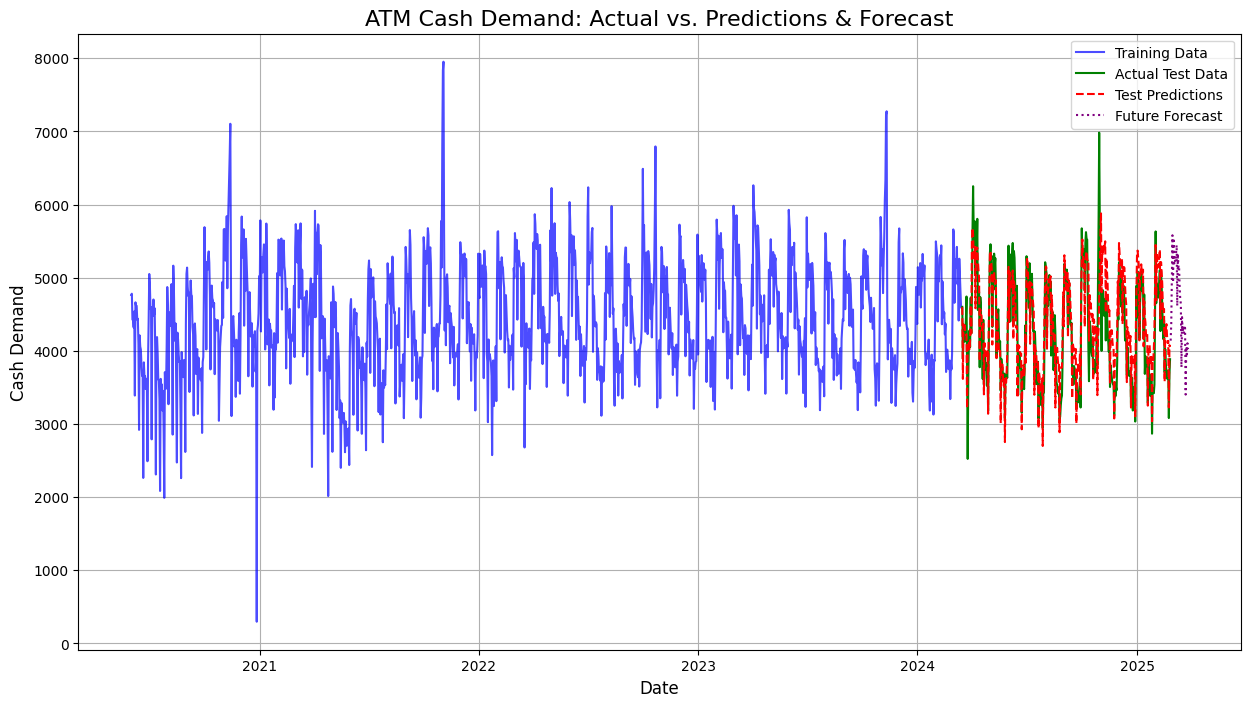

In [ ]:
# Plot results
plt.figure(figsize=(15, 8))
plt.plot(train.index, train.values, label='Training Data', color='blue', alpha=0.7)
plt.plot(test.index, test.values, label='Actual Test Data', color='green')
plt.plot(test.index, test_predictions, label='Test Predictions', color='red', linestyle='--')
plt.plot(future_dates, future_forecast, label='Future Forecast', color='purple', linestyle=':')
plt.title('ATM Cash Demand: Actual vs. Predictions & Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cash Demand', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

**Conclusion:**

In this analysis, four different time series models were evaluated: an Exponential Smoothing model with seasonality and no trend, two SARIMA models (one based on ACF/PACF and another optimized via grid search), and a Dynamic Harmonic Regression (DHR) model. The performance of these models was compared using error metrics such as RMSE, MAE, and MAPE.

Among all the models, the **DHR model** demonstrated the best performance with the **lowest Test RMSE (402.22), Test MAE (308.32), and a Test MAPE of 7.52%**. The optimized **SARIMA model** performed reasonably well with an **RMSE of 446.21**, but it was still outperformed by the DHR model. The Exponential Smoothing model and the initial SARIMA model (based on ACF/PACF) had relatively higher RMSE values, indicating lower predictive accuracy.

**Based on these findings, the DHR model is the most suitable choice as it provides the most accurate forecasts.**